In [19]:
# Import all necessary libraries for multi-class classification
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"   - pandas version: {pd.__version__}")
print(f"   - numpy version: {np.__version__}")
print(f"   - scikit-learn imported")

✅ All libraries imported successfully!
   - pandas version: 2.2.3
   - numpy version: 2.1.3
   - scikit-learn imported


In [20]:
# Upload your CSV file in Colab
# from google.colab import files
# uploaded = files.upload()

# Load the dataset
df = pd.read_csv('network_traffic_multiclass_dataset.csv')

# Display basic info
print("=" * 70)
print("MULTI-CLASS DATASET INFORMATION")
print("=" * 70)
print(f"Total samples: {len(df)}")
print(f"Total features: {len(df.columns) - 1}")

print(f"\n📊 Label distribution:")
label_counts = df['label'].value_counts().sort_index()
for label in label_counts.index:
    label_name = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force'][label]
    print(f"   Label {label} ({label_name:20s}): {label_counts[label]:4d} flows")

print(f"\n📈 Dataset balance:")
balance_pct = (label_counts / len(df) * 100).round(2)
for label in balance_pct.index:
    label_name = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force'][label]
    print(f"   {label_name:20s}: {balance_pct[label]:5.2f}%")

# Check for missing values
print(f"\n🔍 Missing values: {df.isnull().sum().sum()}")
print(f"\n🔍 duplicated values: {df.duplicated().sum().sum()}")
# Display first few rows
print("\n" + "=" * 70)
print("FIRST 5 ROWS:")
print("=" * 70)
df.head()

MULTI-CLASS DATASET INFORMATION
Total samples: 2073
Total features: 35

📊 Label distribution:
   Label 0 (Normal              ):  791 flows
   Label 1 (vsftpd Backdoor     ):  591 flows
   Label 2 (SSH Brute Force     ):  691 flows

📈 Dataset balance:
   Normal              : 38.16%
   vsftpd Backdoor     : 28.51%
   SSH Brute Force     : 33.33%

🔍 Missing values: 0

🔍 duplicated values: 0

FIRST 5 ROWS:


,src_ip,dst_ip,src_port,dst_port,protocol,duration,total_packets,total_bytes,min_packet_size,max_packet_size,...,avg_iat,std_iat,min_iat,max_iat,syn_ack_ratio,is_port_22,is_port_6200,is_ftp_port,is_ftp_data_port,label
0,10.0.2.4,10.0.2.5,44017,22,TCP,2.103768,26,5451,66,1602,...,0.084151,0.385122,9.536743e-07,1.970212,0.080000,1,0,0,0,2
1,192.168.113.129,192.168.113.130,34105,21,TCP,9.837576,19,1331,54,100,...,0.546532,2.243282,0.000000e+00,9.795772,0.142857,0,0,1,0,1
2,10.0.2.4,10.0.2.5,40603,22,TCP,1.887265,26,5451,66,1602,...,0.075491,0.342151,3.004074e-05,1.750835,0.080000,1,0,0,0,2
3,192.168.113.129,192.168.113.130,35668,22,TCP,0.004840,13,3264,66,1602,...,0.000403,0.000673,4.196167e-05,0.002574,0.166667,1,0,0,0,0
4,192.168.113.129,192.168.113.130,41273,21,TCP,9.832887,19,1329,54,100,...,0.546272,2.242975,0.000000e+00,9.794246,0.142857,0,0,1,0,1


In [21]:
# Dataset info
print("=" * 70)
print("DATASET STRUCTURE")
print("=" * 70)
print(df.info())

print("\n" + "=" * 70)
print("STATISTICAL SUMMARY")
print("=" * 70)
df.describe()

DATASET STRUCTURE
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 36 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   src_ip                  2073 non-null   object 
 1   dst_ip                  2073 non-null   object 
 2   src_port                2073 non-null   int64  
 3   dst_port                2073 non-null   int64  
 4   protocol                2073 non-null   object 
 5   duration                2073 non-null   float64
 6   total_packets           2073 non-null   int64  
 7   total_bytes             2073 non-null   int64  
 8   min_packet_size         2073 non-null   int64  
 9   max_packet_size         2073 non-null   int64  
 10  avg_packet_size         2073 non-null   float64
 11  std_packet_size         2073 non-null   float64
 12  syn_count               2073 non-null   int64  
 13  ack_count               2073 non-null   int64  
 14  fin_count             

,src_port,dst_port,duration,total_packets,total_bytes,min_packet_size,max_packet_size,avg_packet_size,std_packet_size,syn_count,...,avg_iat,std_iat,min_iat,max_iat,syn_ack_ratio,is_port_22,is_port_6200,is_ftp_port,is_ftp_data_port,label
count,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,...,2073.000000,2073.000000,2.073000e+03,2073.000000,2073.000000,2073.000000,2073.000000,2073.000000,2073.0,2073.000000
mean,42670.227689,1195.999518,130.542249,23.253739,3605.076218,64.653642,887.618427,152.864506,202.786377,2.052098,...,3.853059,18.473737,5.329064e-05,121.520897,0.188806,0.523396,0.190063,0.285576,0.0,0.951761
std,7100.515089,2424.628277,584.864891,12.687523,2672.903348,8.246425,748.875456,76.540131,185.653918,0.665030,...,34.757071,88.575626,5.637727e-04,543.555304,0.264945,0.499573,0.392445,0.451798,0.0,0.844348
min,68.000000,21.000000,0.000212,2.000000,134.000000,54.000000,74.000000,67.000000,0.000000,0.000000,...,0.000184,0.000000,0.000000e+00,0.000212,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,37293.000000,21.000000,0.006428,13.000000,1406.000000,66.000000,100.000000,73.894737,11.995151,2.000000,...,0.000330,0.000397,9.536743e-07,0.002152,0.080000,0.000000,0.000000,0.000000,0.0,0.000000
50%,41521.000000,22.000000,1.661962,26.000000,3264.000000,66.000000,1602.000000,209.653846,340.877707,2.000000,...,0.066387,0.301267,7.152557e-06,1.540935,0.080000,1.000000,0.000000,0.000000,0.0,1.000000
75%,46067.000000,22.000000,9.826100,29.000000,5451.000000,66.000000,1602.000000,209.653846,340.877707,2.000000,...,0.545874,1.402988,2.312660e-05,5.207952,0.166667,1.000000,0.000000,1.000000,0.0,2.000000
max,60980.000000,6200.000000,5756.946074,105.000000,21870.000000,342.000000,1602.000000,342.000000,441.261559,8.000000,...,1292.540743,1827.928142,2.430296e-02,5198.257350,1.000000,1.000000,1.000000,1.000000,0.0,2.000000


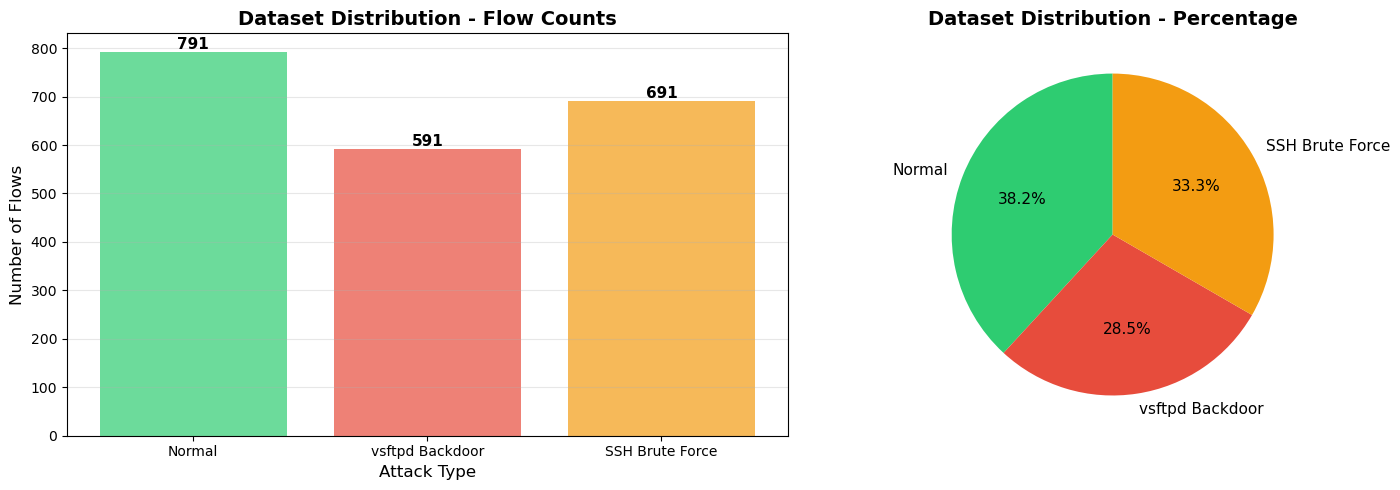


✅ Dataset is well-balanced for multi-class classification!


In [22]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
label_names = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force']
colors = ['#2ecc71', '#e74c3c', '#f39c12']

ax1 = axes[0]
label_counts = df['label'].value_counts().sort_index()
bars = ax1.bar(label_names, label_counts.values, color=colors, alpha=0.7)
ax1.set_xlabel('Attack Type', fontsize=12)
ax1.set_ylabel('Number of Flows', fontsize=12)
ax1.set_title('Dataset Distribution - Flow Counts', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height)}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

# Pie chart
ax2 = axes[1]
ax2.pie(label_counts.values, labels=label_names, colors=colors,
        autopct='%1.1f%%', startangle=90, textprops={'fontsize': 11})
ax2.set_title('Dataset Distribution - Percentage', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Dataset is well-balanced for multi-class classification!")

In [23]:
print("=" * 70)
print("DATA PREPROCESSING")
print("=" * 70)

# Separate features and labels
# X = df.drop(['label'], axis=1) #modified 2 lnes
# y = df['label']

print(f"\n✅ Separated features and labels")
print(f"   Features shape: {X.shape}")
print(f"   Labels shape: {y.shape}")

# Identify categorical and numeric features
categorical_cols = ['src_ip', 'dst_ip', 'protocol']
numeric_cols = [col for col in X.columns if col not in categorical_cols]

print(f"\n📋 Feature types:")
print(f"   Categorical features ({len(categorical_cols)}): {categorical_cols}")
print(f"   Numeric features ({len(numeric_cols)}): {len(numeric_cols)}")

# Encode categorical variables
print(f"\n[*] Encoding categorical features...")
le_dict = {}
for col in categorical_cols:
    # if col in X.columns: #modified
    if col in df.columns:  
        le = LabelEncoder()
        # X[col] = le.fit_transform(X[col].astype(str)) #modified
        df[col] = le.fit_transform(df[col].astype(str))
        le_dict[col] = le
        print(f"   ✅ Encoded {col}: {len(le.classes_)} unique values")

# Handle infinite values
print(f"\n[*] Handling infinite values...")
# inf_count_before = np.isinf(X.values).sum() #modified 2 lines
# X = X.replace([np.inf, -np.inf], 0)
# inf_count_after = np.isinf(X.values).sum()
inf_count_before = np.isinf(df.values).sum() 
df = df.replace([np.inf, -np.inf], 0)
inf_count_after = np.isinf(df.values).sum()
print(f"   ✅ Replaced {inf_count_before} infinite values with 0")

# Check for missing values
# missing_count = X.isnull().sum().sum()#modified 4lines
# if missing_count > 0:
#     print(f"\n⚠️  Found {missing_count} missing values - filling with 0")
#     X = X.fillna(0)
missing_count = df.isnull().sum().sum()
if missing_count > 0:
    print(f"\n⚠️  Found {missing_count} missing values - filling with 0")
    df = df.fillna(0)
else:
    print(f"\n✅ No missing values found")

print("\n" + "=" * 70)
print("✅ PREPROCESSING COMPLETE!")
print("=" * 70)

DATA PREPROCESSING

✅ Separated features and labels
   Features shape: (2073, 35)
   Labels shape: (2073,)

📋 Feature types:
   Categorical features (3): ['src_ip', 'dst_ip', 'protocol']
   Numeric features (32): 32

[*] Encoding categorical features...
   ✅ Encoded src_ip: 3 unique values
   ✅ Encoded dst_ip: 4 unique values
   ✅ Encoded protocol: 2 unique values

[*] Handling infinite values...
   ✅ Replaced 0 infinite values with 0

✅ No missing values found

✅ PREPROCESSING COMPLETE!


In [24]:
# X.info()
df.duplicated().sum()


np.int64(0)

In [25]:
df.nunique() # so we will remove ueg_count and is_ftp_data_port

src_ip                       3
dst_ip                       4
src_port                  1982
dst_port                     5
protocol                     2
duration                  1963
total_packets               39
total_bytes                111
min_packet_size              5
max_packet_size             16
avg_packet_size            103
std_packet_size            150
syn_count                    7
ack_count                   40
fin_count                    6
rst_count                    7
psh_count                   20
urg_count                    1
packets_per_second        1980
bytes_per_second          1985
bytes_per_packet           103
forward_packets             28
backward_packets            28
forward_bytes               97
backward_bytes              69
forward_backward_ratio      39
avg_iat                   1977
std_iat                   1881
min_iat                    238
max_iat                   1910
syn_ack_ratio               35
is_port_22                   2
is_port_

In [26]:
df = df.drop(['is_ftp_data_port', 'urg_count','src_ip','dst_ip'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2073 entries, 0 to 2072
Data columns (total 32 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   src_port                2073 non-null   int64  
 1   dst_port                2073 non-null   int64  
 2   protocol                2073 non-null   int64  
 3   duration                2073 non-null   float64
 4   total_packets           2073 non-null   int64  
 5   total_bytes             2073 non-null   int64  
 6   min_packet_size         2073 non-null   int64  
 7   max_packet_size         2073 non-null   int64  
 8   avg_packet_size         2073 non-null   float64
 9   std_packet_size         2073 non-null   float64
 10  syn_count               2073 non-null   int64  
 11  ack_count               2073 non-null   int64  
 12  fin_count               2073 non-null   int64  
 13  rst_count               2073 non-null   int64  
 14  psh_count               2073 non-null   

In [27]:
# Remove features that are too perfect (cause leakage)
print("=" * 60)
print("REMOVING LEAKY FEATURES")
print("=" * 60)

# Check correlation of each feature with label
correlations = df.corrwith(y).abs().sort_values(ascending=False) #modified X to df
print("\n features correlated with attack desascending:")
print(correlations)
#modified
# # Remove perfect indicators
# leaky_features = ['is_port_6200', 'is_ftp_data_port']  # Port 6200 is too obvious!
# X_cleaned = X.drop(columns=leaky_features, errors='ignore')

# print(f"\n✅ Removed {len(leaky_features)} leaky features")
# print(f"   Features: {leaky_features}")
# print(f"   Remaining features: {len(X_cleaned.columns)}")

# Use cleaned data for splitting
# X = X_cleaned

REMOVING LEAKY FEATURES

 features correlated with attack desascending:
label                     1.000000
bytes_per_second          0.761148
packets_per_second        0.561597
backward_bytes            0.534214
total_bytes               0.531310
forward_bytes             0.517339
src_port                  0.471353
is_ftp_port               0.466138
is_port_22                0.399704
max_packet_size           0.393402
forward_packets           0.298267
max_iat                   0.246645
duration                  0.237790
std_packet_size           0.236472
avg_packet_size           0.227569
bytes_per_packet          0.227569
syn_count                 0.226230
total_packets             0.225411
ack_count                 0.218046
std_iat                   0.208875
fin_count                 0.168334
backward_packets          0.154866
forward_backward_ratio    0.152726
avg_iat                   0.077677
psh_count                 0.064232
syn_ack_ratio             0.033052
dst_port          

In [29]:
X=df.drop('label',axis=1)
y=df['label']

In [30]:
print("=" * 70)
print("TRAIN-TEST SPLIT & FEATURE SCALING")
print("=" * 70)

# Split dataset (80% train, 20% test) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\n📊 Training set:")
train_dist = y_train.value_counts().sort_index()
for label in train_dist.index:
    label_name = ['Normal', 'vsftpd', 'SSH BF'][label]
    print(f"   Label {label} ({label_name:12s}): {train_dist[label]:4d} samples")

print(f"\n📊 Test set:")
test_dist = y_test.value_counts().sort_index()
for label in test_dist.index:
    label_name = ['Normal', 'vsftpd', 'SSH BF'][label]
    print(f"   Label {label} ({label_name:12s}): {test_dist[label]:4d} samples")

print(f"\n✅ Total train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"✅ Total test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%)")

# Feature Scaling
print(f"\n[*] Scaling features using StandardScaler...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Features scaled successfully")
print(f"   Train shape: {X_train_scaled.shape}")
print(f"   Test shape:  {X_test_scaled.shape}")

print("\n" + "=" * 70)
print("✅ DATA SPLIT & SCALING COMPLETE!")
print("=" * 70)

TRAIN-TEST SPLIT & FEATURE SCALING

📊 Training set:
   Label 0 (Normal      ):  632 samples
   Label 1 (vsftpd      ):  473 samples
   Label 2 (SSH BF      ):  553 samples

📊 Test set:
   Label 0 (Normal      ):  159 samples
   Label 1 (vsftpd      ):  118 samples
   Label 2 (SSH BF      ):  138 samples

✅ Total train: 1658 samples (80.0%)
✅ Total test:  415 samples (20.0%)

[*] Scaling features using StandardScaler...
✅ Features scaled successfully
   Train shape: (1658, 31)
   Test shape:  (415, 31)

✅ DATA SPLIT & SCALING COMPLETE!


In [31]:
# Check for leaky features
print("=" * 60)
print("CHECKING FOR FEATURE LEAKAGE")
print("=" * 60)

# Check correlation with label
correlations = X_train.corrwith(y_train).abs().sort_values(ascending=False)

print("\nTop 10 features correlated with label:")
print(correlations.head(10))

print("\n⚠️ Features with >0.95 correlation (LEAKY):")
leaky = correlations[correlations > 0.95]
if len(leaky) > 0:
    print(leaky)
    print("\n🚨 THESE FEATURES CAUSE OVERFITTING!")
else:
    print("✅ No obvious leaky features found")

# Check if port_6200 feature exists
if 'is_port_6200' in X_train.columns:
    print("\n🚨 WARNING: 'is_port_6200' is still in dataset!")
    print("   This is a PERFECT attack indicator - causes 100% overfitting")
    port_6200_corr = X_train['is_port_6200'].corr(y_train)
    print(f"   Correlation with label: {port_6200_corr:.4f}")

CHECKING FOR FEATURE LEAKAGE

Top 10 features correlated with label:
bytes_per_second          0.759784
packets_per_second        0.554226
backward_bytes            0.532994
total_bytes               0.528334
forward_bytes             0.513578
src_port                  0.480889
is_ftp_port               0.457486
forward_backward_ratio    0.399824
is_port_22                0.390311
max_packet_size           0.384057
dtype: float64

⚠️ Features with >0.95 correlation (LEAKY):
✅ No obvious leaky features found

🚨 WARNING: 'is_port_6200' is still in dataset!
   This is a PERFECT attack indicator - causes 100% overfitting
   Correlation with label: 0.0274


FEATURE SELECTION - ANOVA F-TEST (Multi-Class)

[*] Selecting top 15 features using ANOVA F-test...

✅ Selected 15 best features using ANOVA:
    1. dst_port                       (F-Score:    1190.13)
    2. total_bytes                    (F-Score:    1866.78)
    3. max_packet_size                (F-Score:    1400.70)
    4. avg_packet_size                (F-Score:     902.90)
    5. std_packet_size                (F-Score:     835.76)
    6. ack_count                      (F-Score:     432.22)
    7. rst_count                      (F-Score:     476.81)
    8. bytes_per_second               (F-Score:    1207.34)
    9. bytes_per_packet               (F-Score:     902.90)
   10. backward_packets               (F-Score:     418.79)
   11. forward_bytes                  (F-Score:    1630.10)
   12. backward_bytes                 (F-Score:    1894.68)
   13. forward_backward_ratio         (F-Score:    1599.66)
   14. is_port_22                     (F-Score:    1337.47)
   15. is_port_620

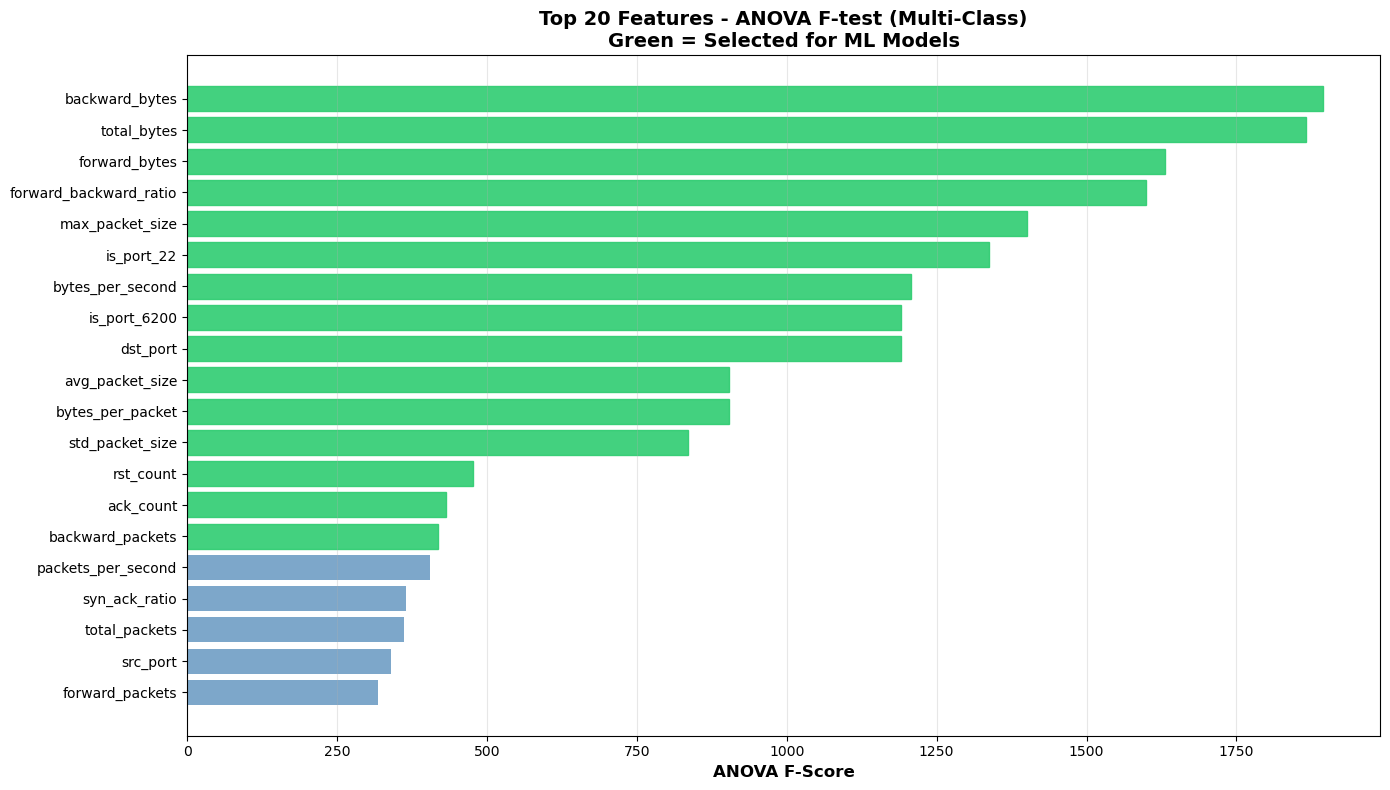


✅ Feature selection complete!
   Original features: 31
   Selected features: 15


In [32]:
print("=" * 70)
print("FEATURE SELECTION - ANOVA F-TEST (Multi-Class)")
print("=" * 70)

# Select top K features using ANOVA F-test
k_best = 15  # Select top 15 features
print(f"\n[*] Selecting top {k_best} features using ANOVA F-test...")

selector_anova = SelectKBest(score_func=f_classif, k=k_best)
X_train_anova = selector_anova.fit_transform(X_train_scaled, y_train)
X_test_anova = selector_anova.transform(X_test_scaled)

# Get selected feature names
selected_features_anova = X_train.columns[selector_anova.get_support()].tolist()

print(f"\n✅ Selected {k_best} best features using ANOVA:")
for i, feature in enumerate(selected_features_anova, 1):
    feature_idx = X_train.columns.get_loc(feature)
    score = selector_anova.scores_[feature_idx]
    print(f"   {i:2d}. {feature:30s} (F-Score: {score:10.2f})")

# Visualize feature scores
print(f"\n[*] Creating feature importance visualization...")

feature_scores_df = pd.DataFrame({
    'Feature': X_train.columns,
    'F_Score': selector_anova.scores_
}).sort_values('F_Score', ascending=False)

plt.figure(figsize=(14, 8))
top_20 = feature_scores_df.head(20)
bars = plt.barh(range(len(top_20)), top_20['F_Score'], color='steelblue', alpha=0.7)

# Highlight selected features
for i, (idx, row) in enumerate(top_20.iterrows()):
    if row['Feature'] in selected_features_anova:
        bars[i].set_color('#2ecc71')  # Green for selected
        bars[i].set_alpha(0.9)

plt.yticks(range(len(top_20)), top_20['Feature'])
plt.xlabel('ANOVA F-Score', fontsize=12, fontweight='bold')
plt.title(f'Top 20 Features - ANOVA F-test (Multi-Class)\nGreen = Selected for ML Models',
          fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n✅ Feature selection complete!")
print(f"   Original features: {X_train_scaled.shape[1]}")
print(f"   Selected features: {X_train_anova.shape[1]}")

In [33]:
print("=" * 70)
print("FEATURE SELECTION - RFE (Recursive Feature Elimination)")
print("=" * 70)

# Use Random Forest as estimator for RFE
print(f"\n[*] Running RFE with Random Forest estimator...")
rf_estimator = RandomForestClassifier(n_estimators=50, max_depth=10, random_state=42)
rfe_selector = RFE(estimator=rf_estimator, n_features_to_select=15, step=1)

X_train_rfe = rfe_selector.fit_transform(X_train_scaled, y_train)
X_test_rfe = rfe_selector.transform(X_test_scaled)

# Get selected feature names
selected_features_rfe = X_train.columns[rfe_selector.get_support()].tolist()

print(f"\n✅ Selected 15 features using RFE:")
for i, feature in enumerate(selected_features_rfe, 1):
    ranking = rfe_selector.ranking_[X_train.columns.get_loc(feature)]
    print(f"   {i:2d}. {feature:30s} (Rank: {ranking})")

print(f"\n✅ RFE feature selection complete!")

FEATURE SELECTION - RFE (Recursive Feature Elimination)

[*] Running RFE with Random Forest estimator...

✅ Selected 15 features using RFE:
    1. src_port                       (Rank: 1)
    2. duration                       (Rank: 1)
    3. total_bytes                    (Rank: 1)
    4. max_packet_size                (Rank: 1)
    5. avg_packet_size                (Rank: 1)
    6. std_packet_size                (Rank: 1)
    7. psh_count                      (Rank: 1)
    8. bytes_per_packet               (Rank: 1)
    9. forward_bytes                  (Rank: 1)
   10. backward_bytes                 (Rank: 1)
   11. forward_backward_ratio         (Rank: 1)
   12. std_iat                        (Rank: 1)
   13. max_iat                        (Rank: 1)
   14. syn_ack_ratio                  (Rank: 1)
   15. is_port_22                     (Rank: 1)

✅ RFE feature selection complete!


FEATURE SELECTION COMPARISON

📊 ANOVA Selected Features:
    1. dst_port
    2. total_bytes
    3. max_packet_size
    4. avg_packet_size
    5. std_packet_size
    6. ack_count
    7. rst_count
    8. bytes_per_second
    9. bytes_per_packet
   10. backward_packets
   11. forward_bytes
   12. backward_bytes
   13. forward_backward_ratio
   14. is_port_22
   15. is_port_6200

📊 RFE Selected Features:
    1. src_port
    2. duration
    3. total_bytes
    4. max_packet_size
    5. avg_packet_size
    6. std_packet_size
    7. psh_count
    8. bytes_per_packet
    9. forward_bytes
   10. backward_bytes
   11. forward_backward_ratio
   12. std_iat
   13. max_iat
   14. syn_ack_ratio
   15. is_port_22

🔄 Common features (9):
    1. avg_packet_size
    2. backward_bytes
    3. bytes_per_packet
    4. forward_backward_ratio
    5. forward_bytes
    6. is_port_22
    7. max_packet_size
    8. std_packet_size
    9. total_bytes

📍 ANOVA only (6): ['ack_count', 'backward_packets', 'bytes_per_se

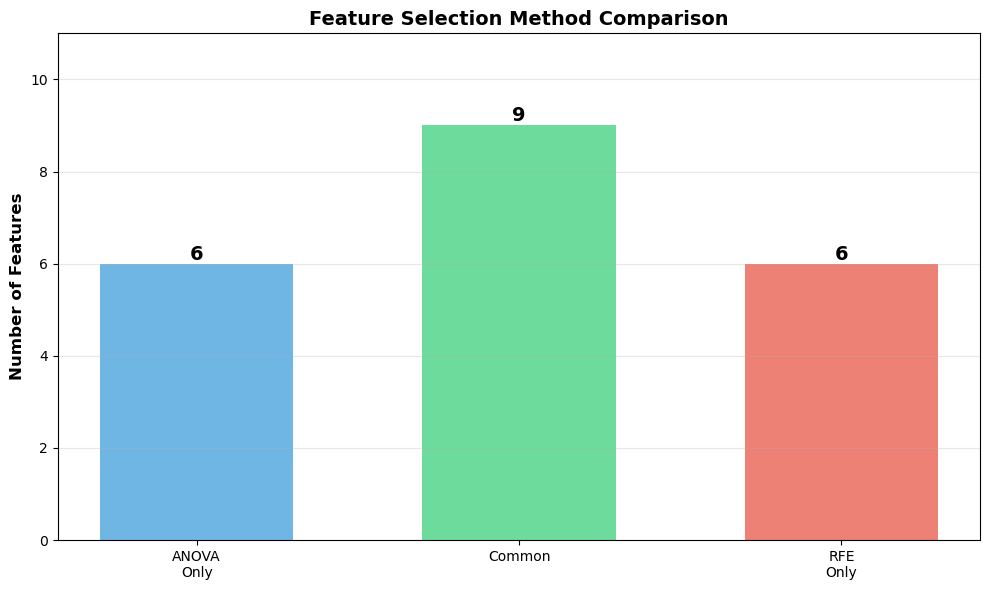


✅ Using ANOVA-selected 15 features for ML models

✅ FEATURE SELECTION COMPLETE!


In [34]:
print("=" * 70)
print("FEATURE SELECTION COMPARISON")
print("=" * 70)

print("\n📊 ANOVA Selected Features:")
for i, f in enumerate(selected_features_anova, 1):
    print(f"   {i:2d}. {f}")

print("\n📊 RFE Selected Features:")
for i, f in enumerate(selected_features_rfe, 1):
    print(f"   {i:2d}. {f}")

# Find common features
common_features = set(selected_features_anova) & set(selected_features_rfe)
print(f"\n🔄 Common features ({len(common_features)}):")
for i, f in enumerate(sorted(common_features), 1):
    print(f"   {i:2d}. {f}")

# Features unique to each method
anova_only = set(selected_features_anova) - set(selected_features_rfe)
rfe_only = set(selected_features_rfe) - set(selected_features_anova)

print(f"\n📍 ANOVA only ({len(anova_only)}): {sorted(anova_only)}")
print(f"📍 RFE only ({len(rfe_only)}): {sorted(rfe_only)}")

# Visualize comparison
fig, ax = plt.subplots(figsize=(10, 6))

categories = ['ANOVA\nOnly', 'Common', 'RFE\nOnly']
counts = [len(anova_only), len(common_features), len(rfe_only)]
colors_bar = ['#3498db', '#2ecc71', '#e74c3c']

bars = ax.bar(categories, counts, color=colors_bar, alpha=0.7, width=0.6)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}',
            ha='center', va='bottom', fontsize=14, fontweight='bold')

ax.set_ylabel('Number of Features', fontsize=12, fontweight='bold')
ax.set_title('Feature Selection Method Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, max(counts) + 2])
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# For ML models, we'll use ANOVA-selected features
X_train_final = X_train_anova
X_test_final = X_test_anova
selected_features_final = selected_features_anova

print(f"\n✅ Using ANOVA-selected {len(selected_features_final)} features for ML models")
print("\n" + "=" * 70)
print("✅ FEATURE SELECTION COMPLETE!")
print("=" * 70)

In [35]:
print("=" * 70)
print("TRAINING MULTI-CLASS ML MODELS")
print("=" * 70)

# Dictionary to store models with regularization
models = {
    'Random Forest': RandomForestClassifier(
        n_estimators=100,
        max_depth=15,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'SVM': SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        random_state=42
    ),
    'Decision Tree': DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42
    ),
    'Naive Bayes': GaussianNB(),
    'Logistic Regression': LogisticRegression(
        multi_class='multinomial',  # Important for multi-class!
        solver='lbfgs',
        C=1.0,
        max_iter=1000,
        random_state=42
    )
}

# Dictionary to store results
results = {}

print(f"\n[*] Training {len(models)} models on multi-class data...")
print(f"[*] Classes: 0=Normal, 1=vsftpd Backdoor, 2=SSH Brute Force")

# Train each model
for name, model in models.items():
    print(f"\n{'='*70}")
    print(f"[*] Training {name}...")
    print(f"{'='*70}")

    # Train on full training set
    model.fit(X_train_final, y_train)

    # Predictions on train and test sets
    y_train_pred = model.predict(X_train_final)
    y_test_pred = model.predict(X_test_final)

    # Calculate metrics for multi-class
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)

    # Multi-class metrics (weighted average)
    precision = precision_score(y_test, y_test_pred, average='weighted')
    recall = recall_score(y_test, y_test_pred, average='weighted')
    f1 = f1_score(y_test, y_test_pred, average='weighted')

    # Per-class metrics
    precision_per_class = precision_score(y_test, y_test_pred, average=None)
    recall_per_class = recall_score(y_test, y_test_pred, average=None)
    f1_per_class = f1_score(y_test, y_test_pred, average=None)

    results[name] = {
        'model': model,
        'train_predictions': y_train_pred,
        'test_predictions': y_test_pred,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'accuracy': test_accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'precision_per_class': precision_per_class,
        'recall_per_class': recall_per_class,
        'f1_per_class': f1_per_class,
        'overfitting': train_accuracy - test_accuracy
    }

    print(f"✅ {name} trained successfully!")
    print(f"   Train Accuracy: {train_accuracy:.4f}")
    print(f"   Test Accuracy:  {test_accuracy:.4f}")
    print(f"   Precision (weighted): {precision:.4f}")
    print(f"   Recall (weighted):    {recall:.4f}")
    print(f"   F1-Score (weighted):  {f1:.4f}")
    print(f"   Overfitting Gap: {train_accuracy - test_accuracy:.4f}")

print("\n" + "=" * 70)
print("✅ ALL MODELS TRAINED SUCCESSFULLY!")
print("=" * 70)

TRAINING MULTI-CLASS ML MODELS

[*] Training 5 models on multi-class data...
[*] Classes: 0=Normal, 1=vsftpd Backdoor, 2=SSH Brute Force

[*] Training Random Forest...
✅ Random Forest trained successfully!
   Train Accuracy: 0.9994
   Test Accuracy:  0.9976
   Precision (weighted): 0.9976
   Recall (weighted):    0.9976
   F1-Score (weighted):  0.9976
   Overfitting Gap: 0.0018

[*] Training SVM...
✅ SVM trained successfully!
   Train Accuracy: 0.9970
   Test Accuracy:  0.9976
   Precision (weighted): 0.9976
   Recall (weighted):    0.9976
   F1-Score (weighted):  0.9976
   Overfitting Gap: -0.0006

[*] Training Decision Tree...
✅ Decision Tree trained successfully!
   Train Accuracy: 0.9994
   Test Accuracy:  0.9976
   Precision (weighted): 0.9976
   Recall (weighted):    0.9976
   F1-Score (weighted):  0.9976
   Overfitting Gap: 0.0018

[*] Training Naive Bayes...
✅ Naive Bayes trained successfully!
   Train Accuracy: 0.9994
   Test Accuracy:  1.0000
   Precision (weighted): 1.0000
 

In [36]:
print("=" * 80)
print("MULTI-CLASS MODEL EVALUATION - OVERALL METRICS")
print("=" * 80)

# Create results DataFrame
results_df = pd.DataFrame({
    'Model': list(results.keys()),
    'Train Accuracy': [results[m]['train_accuracy'] for m in results.keys()],
    'Test Accuracy': [results[m]['test_accuracy'] for m in results.keys()],
    'Precision': [results[m]['precision'] for m in results.keys()],
    'Recall': [results[m]['recall'] for m in results.keys()],
    'F1-Score': [results[m]['f1_score'] for m in results.keys()],
    'Overfitting Gap': [results[m]['overfitting'] for m in results.keys()]
})

# Sort by F1-Score
results_df = results_df.sort_values('F1-Score', ascending=False)

print("\n📊 PERFORMANCE METRICS (Weighted Average):")
print(results_df.to_string(index=False))

# Find best model
best_model_name = results_df.iloc[0]['Model']
best_f1 = results_df.iloc[0]['F1-Score']
best_acc = results_df.iloc[0]['Test Accuracy']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"   Test Accuracy: {best_acc:.4f}")
print(f"   F1-Score: {best_f1:.4f}")

# Check overfitting
print(f"\n⚠️  Overfitting Analysis:")
for _, row in results_df.iterrows():
    gap = row['Overfitting Gap']
    status = "✅ Good" if gap < 0.05 else "⚠️ Slight" if gap < 0.10 else "🚨 High"
    print(f"   {row['Model']:20s}: Gap = {gap:.4f} {status}")

MULTI-CLASS MODEL EVALUATION - OVERALL METRICS

📊 PERFORMANCE METRICS (Weighted Average):
              Model  Train Accuracy  Test Accuracy  Precision  Recall  F1-Score  Overfitting Gap
        Naive Bayes        0.999397        1.00000   1.000000 1.00000  1.000000        -0.000603
Logistic Regression        0.997587        0.99759   0.997608 0.99759  0.997591        -0.000003
                SVM        0.996984        0.99759   0.997608 0.99759  0.997591        -0.000606
      Random Forest        0.999397        0.99759   0.997605 0.99759  0.997589         0.001807
      Decision Tree        0.999397        0.99759   0.997605 0.99759  0.997589         0.001807

🏆 BEST MODEL: Naive Bayes
   Test Accuracy: 1.0000
   F1-Score: 1.0000

⚠️  Overfitting Analysis:
   Naive Bayes         : Gap = -0.0006 ✅ Good
   Logistic Regression : Gap = -0.0000 ✅ Good
   SVM                 : Gap = -0.0006 ✅ Good
   Random Forest       : Gap = 0.0018 ✅ Good
   Decision Tree       : Gap = 0.0018 ✅ Good


In [37]:
print("=" * 80)
print("PER-CLASS PERFORMANCE ANALYSIS")
print("=" * 80)

class_names = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force']

for model_name, result in results.items():
    print(f"\n{'='*80}")
    print(f"📊 {model_name} - Per-Class Metrics")
    print(f"{'='*80}")

    per_class_df = pd.DataFrame({
        'Class': class_names,
        'Precision': result['precision_per_class'],
        'Recall': result['recall_per_class'],
        'F1-Score': result['f1_per_class']
    })

    print(per_class_df.to_string(index=False))
    print()

# Create comprehensive per-class comparison
print("\n" + "=" * 80)
print("PER-CLASS F1-SCORE COMPARISON (All Models)")
print("=" * 80)

comparison_data = []
for model_name, result in results.items():
    for i, class_name in enumerate(class_names):
        comparison_data.append({
            'Model': model_name,
            'Class': class_name,
            'F1-Score': result['f1_per_class'][i]
        })

comparison_df = pd.DataFrame(comparison_data)

# Pivot for better view
pivot_df = comparison_df.pivot(index='Model', columns='Class', values='F1-Score')
print(pivot_df.to_string())

PER-CLASS PERFORMANCE ANALYSIS

📊 Random Forest - Per-Class Metrics
          Class  Precision   Recall  F1-Score
         Normal    0.99375 1.000000  0.996865
vsftpd Backdoor    1.00000 0.991525  0.995745
SSH Brute Force    1.00000 1.000000  1.000000


📊 SVM - Per-Class Metrics
          Class  Precision   Recall  F1-Score
         Normal   1.000000 0.993711  0.996845
vsftpd Backdoor   1.000000 1.000000  1.000000
SSH Brute Force   0.992806 1.000000  0.996390


📊 Decision Tree - Per-Class Metrics
          Class  Precision   Recall  F1-Score
         Normal    0.99375 1.000000  0.996865
vsftpd Backdoor    1.00000 0.991525  0.995745
SSH Brute Force    1.00000 1.000000  1.000000


📊 Naive Bayes - Per-Class Metrics
          Class  Precision  Recall  F1-Score
         Normal        1.0     1.0       1.0
vsftpd Backdoor        1.0     1.0       1.0
SSH Brute Force        1.0     1.0       1.0


📊 Logistic Regression - Per-Class Metrics
          Class  Precision   Recall  F1-Score
        

VISUALIZING MODEL PERFORMANCE


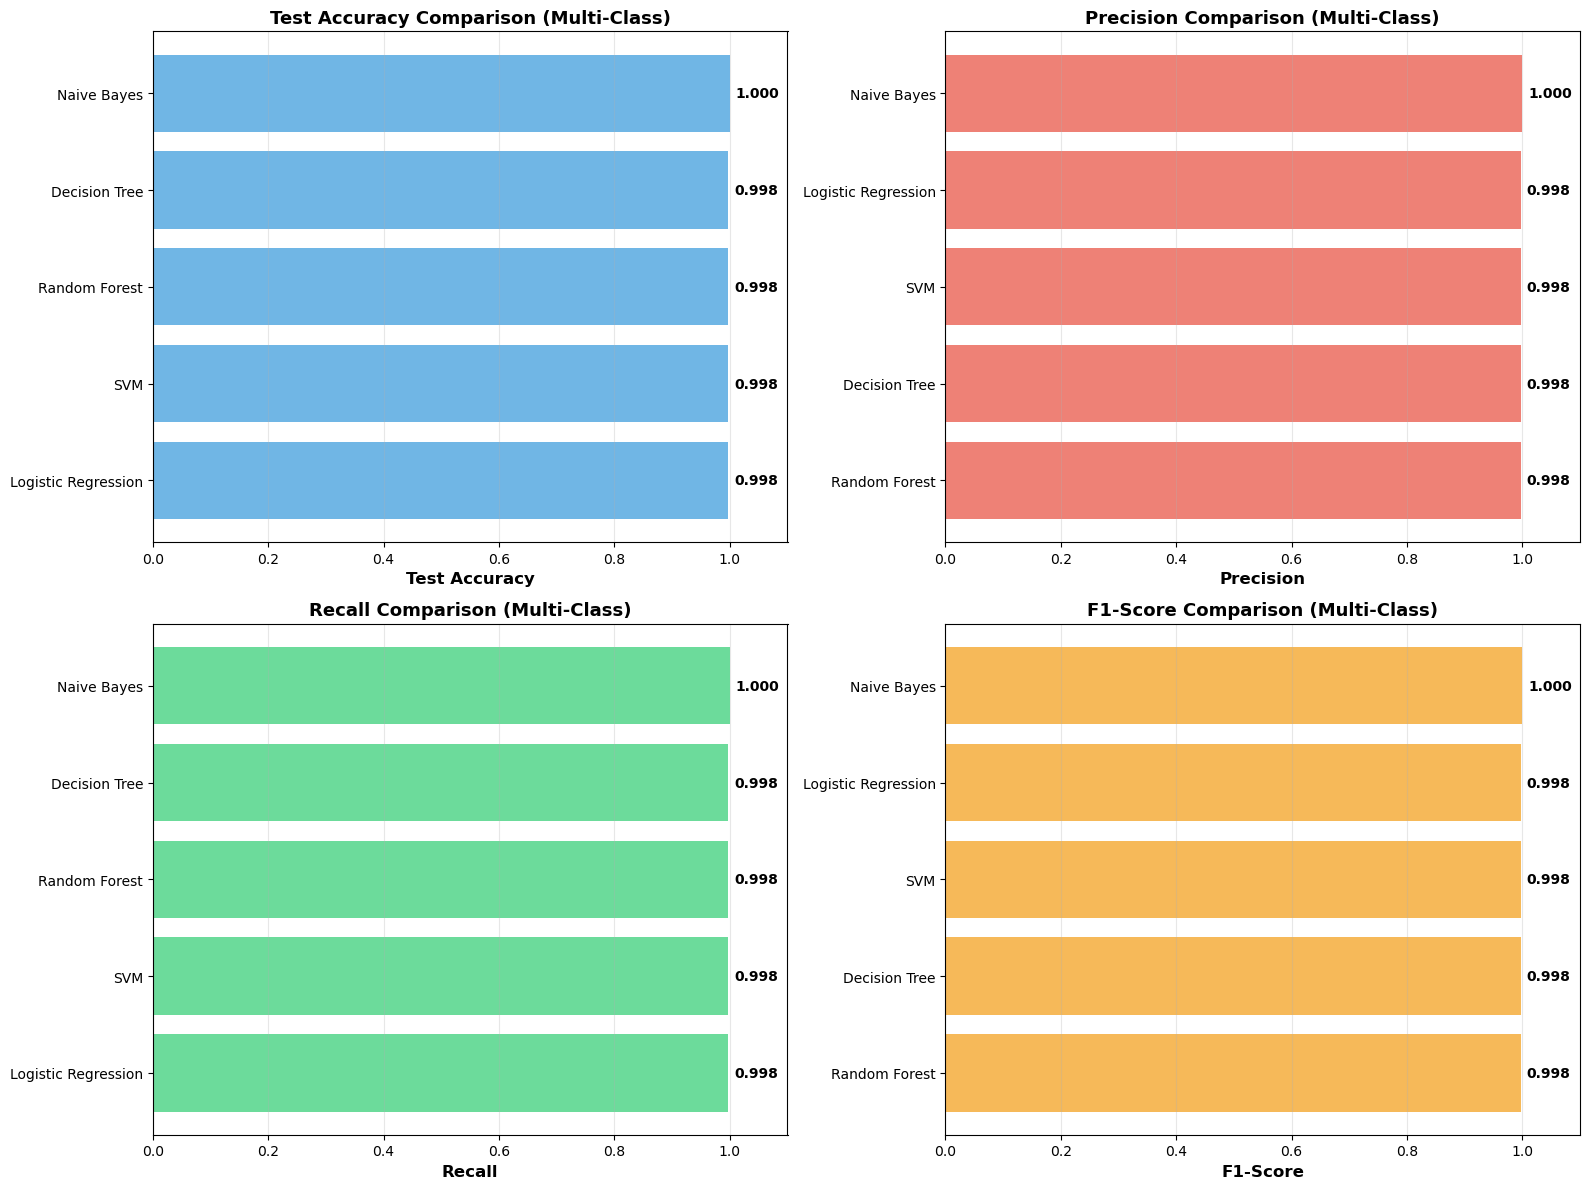

✅ Model comparison visualization complete!


In [38]:
print("=" * 70)
print("VISUALIZING MODEL PERFORMANCE")
print("=" * 70)

# Create comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['Test Accuracy', 'Precision', 'Recall', 'F1-Score']
colors_metrics = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']

for idx, (ax, metric, color) in enumerate(zip(axes.flat, metrics, colors_metrics)):
    sorted_data = results_df.sort_values(metric, ascending=True)
    bars = ax.barh(sorted_data['Model'], sorted_data[metric], color=color, alpha=0.7)

    ax.set_xlabel(metric, fontsize=12, fontweight='bold')
    ax.set_title(f'{metric} Comparison (Multi-Class)', fontsize=13, fontweight='bold')
    ax.set_xlim([0, 1.1])
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, v) in enumerate(zip(bars, sorted_data[metric])):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("✅ Model comparison visualization complete!")

OVERFITTING ANALYSIS - TRAIN VS TEST ACCURACY


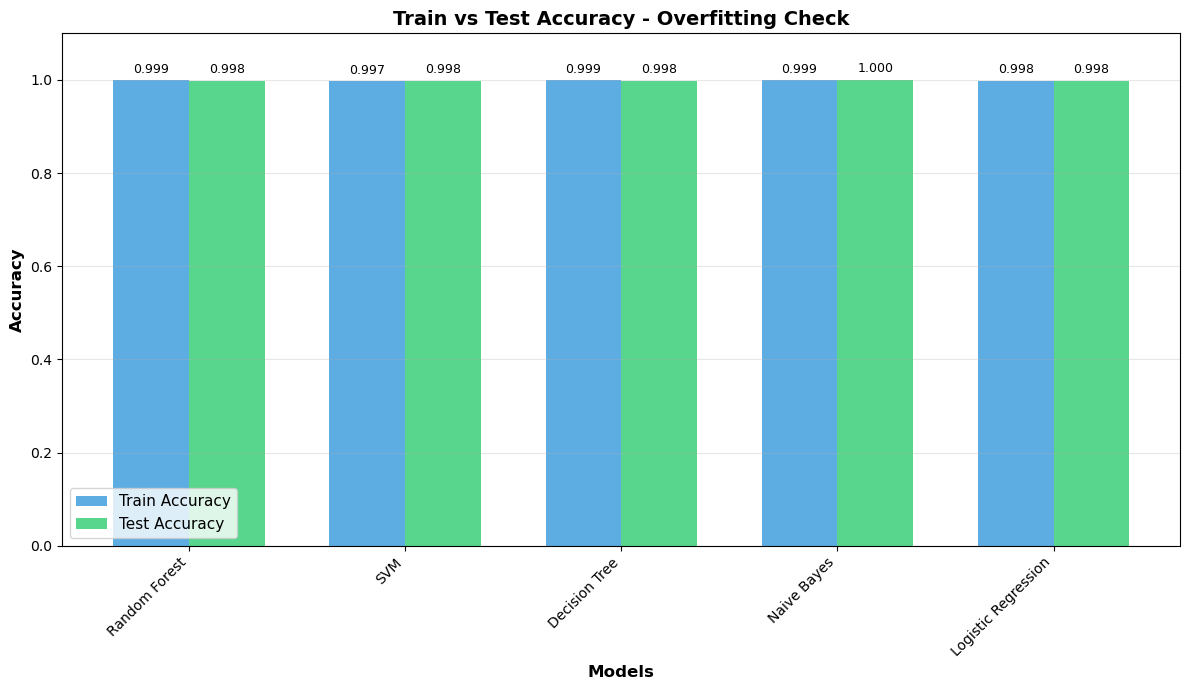


📊 Overfitting Summary:
   Gap < 0.05:  Excellent generalization ✅
   Gap 0.05-0.10: Good generalization ⚠️
   Gap > 0.10: Overfitting detected 🚨

   Random Forest       : 0.0018 ✅
   SVM                 : -0.0006 ✅
   Decision Tree       : 0.0018 ✅
   Naive Bayes         : -0.0006 ✅
   Logistic Regression : -0.0000 ✅


In [39]:
print("=" * 70)
print("OVERFITTING ANALYSIS - TRAIN VS TEST ACCURACY")
print("=" * 70)

# Visualize train vs test accuracy
fig, ax = plt.subplots(figsize=(12, 7))

x = np.arange(len(results))
width = 0.35

train_accs = [results[m]['train_accuracy'] for m in results.keys()]
test_accs = [results[m]['test_accuracy'] for m in results.keys()]

bars1 = ax.bar(x - width/2, train_accs, width, label='Train Accuracy',
               color='#3498db', alpha=0.8)
bars2 = ax.bar(x + width/2, test_accs, width, label='Test Accuracy',
               color='#2ecc71', alpha=0.8)

ax.set_xlabel('Models', fontsize=12, fontweight='bold')
ax.set_ylabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_title('Train vs Test Accuracy - Overfitting Check', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(results.keys(), rotation=45, ha='right')
ax.legend(fontsize=11)
ax.set_ylim([0, 1.1])
ax.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print overfitting summary
print("\n📊 Overfitting Summary:")
print("   Gap < 0.05:  Excellent generalization ✅")
print("   Gap 0.05-0.10: Good generalization ⚠️")
print("   Gap > 0.10: Overfitting detected 🚨")
print()

for model_name in results.keys():
    gap = results[model_name]['overfitting']
    status = "✅" if gap < 0.05 else "⚠️" if gap < 0.10 else "🚨"
    print(f"   {model_name:20s}: {gap:.4f} {status}")

CONFUSION MATRICES - MULTI-CLASS


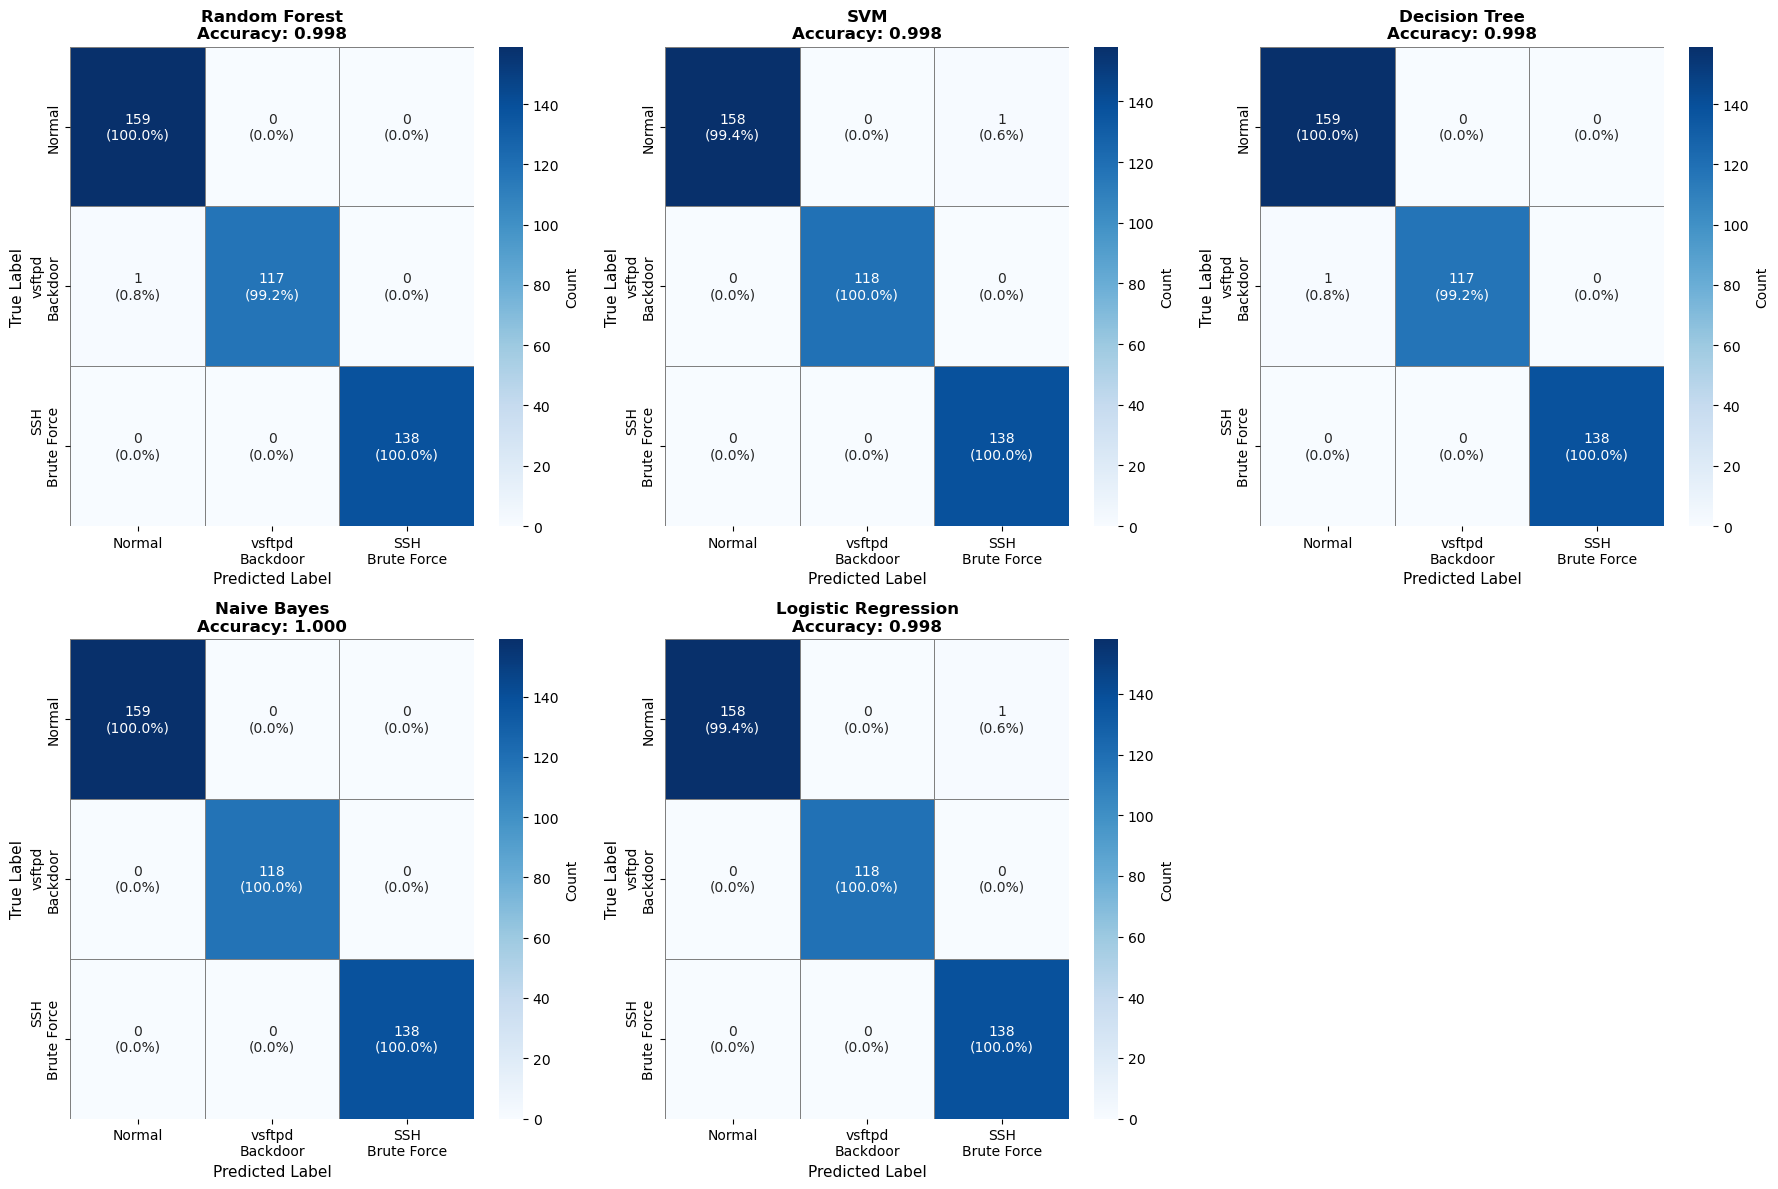

✅ Confusion matrices visualization complete!


In [40]:
print("=" * 70)
print("CONFUSION MATRICES - MULTI-CLASS")
print("=" * 70)

# Plot confusion matrices for all models
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.ravel()

class_names = ['Normal', 'vsftpd\nBackdoor', 'SSH\nBrute Force']

for idx, (name, result) in enumerate(results.items()):
    cm = confusion_matrix(y_test, result['test_predictions'])

    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100

    # Create annotations with both count and percentage
    annot = np.empty_like(cm, dtype=object)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f'{cm[i, j]}\n({cm_percent[i, j]:.1f}%)'

    # Plot heatmap
    sns.heatmap(cm, annot=annot, fmt='', cmap='Blues', ax=axes[idx],
                xticklabels=class_names,
                yticklabels=class_names,
                cbar_kws={'label': 'Count'},
                linewidths=0.5,
                linecolor='gray')

    acc = result['test_accuracy']
    axes[idx].set_title(f'{name}\nAccuracy: {acc:.3f}',
                        fontsize=12, fontweight='bold')
    axes[idx].set_ylabel('True Label', fontsize=11)
    axes[idx].set_xlabel('Predicted Label', fontsize=11)

# Hide extra subplot
axes[-1].axis('off')

plt.tight_layout()
plt.show()

print("✅ Confusion matrices visualization complete!")

In [41]:
print("=" * 80)
print(f"DETAILED CLASSIFICATION REPORT - {best_model_name}")
print("=" * 80)

# Get best model predictions
best_model = results[best_model_name]['model']
best_predictions = results[best_model_name]['test_predictions']

# Full classification report
class_names_full = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force']
print("\n" + classification_report(y_test, best_predictions,
                                    target_names=class_names_full,
                                    digits=4))

# Confusion Matrix for best model
print(f"\n{'='*80}")
print("CONFUSION MATRIX - BEST MODEL")
print(f"{'='*80}")

cm = confusion_matrix(y_test, best_predictions)
cm_df = pd.DataFrame(cm,
                     index=['Actual: Normal', 'Actual: vsftpd', 'Actual: SSH BF'],
                     columns=['Pred: Normal', 'Pred: vsftpd', 'Pred: SSH BF'])

print("\n", cm_df)

# Calculate per-class accuracy
print(f"\n{'='*80}")
print("PER-CLASS ACCURACY")
print(f"{'='*80}")

for i, class_name in enumerate(class_names_full):
    class_correct = cm[i, i]
    class_total = cm[i, :].sum()
    class_acc = class_correct / class_total if class_total > 0 else 0
    print(f"   {class_name:20s}: {class_acc:.4f} ({class_correct}/{class_total})")

# Misclassification analysis
print(f"\n{'='*80}")
print("MISCLASSIFICATION ANALYSIS")
print(f"{'='*80}")

total_misclassified = len(y_test) - np.trace(cm)
print(f"\nTotal misclassified: {total_misclassified} / {len(y_test)} ({total_misclassified/len(y_test)*100:.2f}%)")

if total_misclassified > 0:
    print("\nMisclassification breakdown:")
    for i in range(len(class_names_full)):
        for j in range(len(class_names_full)):
            if i != j and cm[i, j] > 0:
                print(f"   {class_names_full[i]} → {class_names_full[j]}: {cm[i, j]} samples")
else:
    print("\n🎉 PERFECT CLASSIFICATION - No misclassifications!")

DETAILED CLASSIFICATION REPORT - Naive Bayes

                 precision    recall  f1-score   support

         Normal     1.0000    1.0000    1.0000       159
vsftpd Backdoor     1.0000    1.0000    1.0000       118
SSH Brute Force     1.0000    1.0000    1.0000       138

       accuracy                         1.0000       415
      macro avg     1.0000    1.0000    1.0000       415
   weighted avg     1.0000    1.0000    1.0000       415


CONFUSION MATRIX - BEST MODEL

                 Pred: Normal  Pred: vsftpd  Pred: SSH BF
Actual: Normal           159             0             0
Actual: vsftpd             0           118             0
Actual: SSH BF             0             0           138

PER-CLASS ACCURACY
   Normal              : 1.0000 (159/159)
   vsftpd Backdoor     : 1.0000 (118/118)
   SSH Brute Force     : 1.0000 (138/138)

MISCLASSIFICATION ANALYSIS

Total misclassified: 0 / 415 (0.00%)

🎉 PERFECT CLASSIFICATION - No misclassifications!


FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST

📊 Feature Importance Ranking:
               Feature  Importance
        backward_bytes    0.173121
         forward_bytes    0.159591
       max_packet_size    0.127761
           total_bytes    0.113071
      bytes_per_packet    0.097419
       std_packet_size    0.088973
forward_backward_ratio    0.087157
       avg_packet_size    0.074928
      bytes_per_second    0.046135
      backward_packets    0.009901
              dst_port    0.007816
            is_port_22    0.006722
             ack_count    0.004899
             rst_count    0.002507
          is_port_6200    0.000000


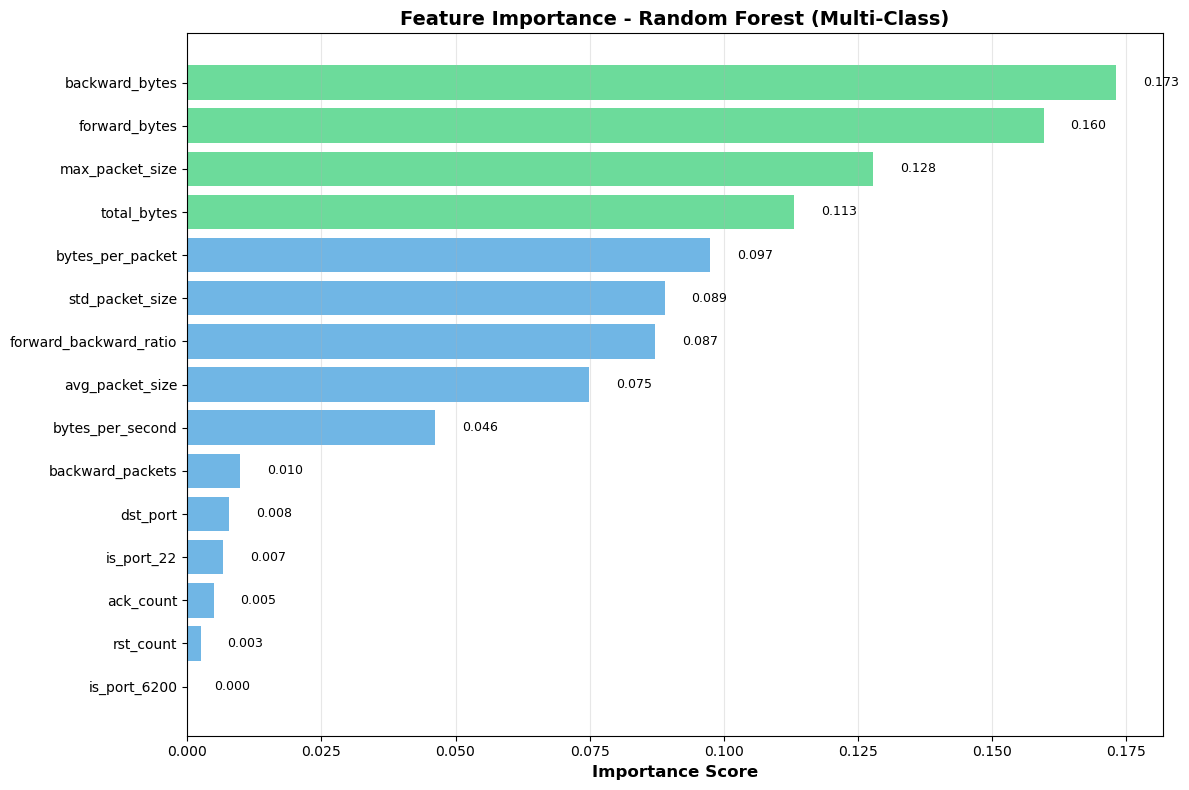


✅ Feature importance analysis complete!


In [42]:
print("=" * 70)
print("FEATURE IMPORTANCE ANALYSIS - RANDOM FOREST")
print("=" * 70)

if 'Random Forest' in results:
    rf_model = results['Random Forest']['model']

    # Get feature importance
    feature_importance = pd.DataFrame({
        'Feature': selected_features_final,
        'Importance': rf_model.feature_importances_
    }).sort_values('Importance', ascending=False)

    print("\n📊 Feature Importance Ranking:")
    print(feature_importance.to_string(index=False))

    # Visualize
    plt.figure(figsize=(12, 8))
    colors_bars = ['#2ecc71' if imp > 0.1 else '#3498db' for imp in feature_importance['Importance']]
    bars = plt.barh(range(len(feature_importance)), feature_importance['Importance'],
                    color=colors_bars, alpha=0.7)

    plt.yticks(range(len(feature_importance)), feature_importance['Feature'])
    plt.xlabel('Importance Score', fontsize=12, fontweight='bold')
    plt.title('Feature Importance - Random Forest (Multi-Class)',
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, feature_importance['Importance'])):
        plt.text(imp + 0.005, i, f'{imp:.3f}', va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

    print("\n✅ Feature importance analysis complete!")
else:
    print("⚠️ Random Forest model not found in results")

PER-CLASS F1-SCORE HEATMAP


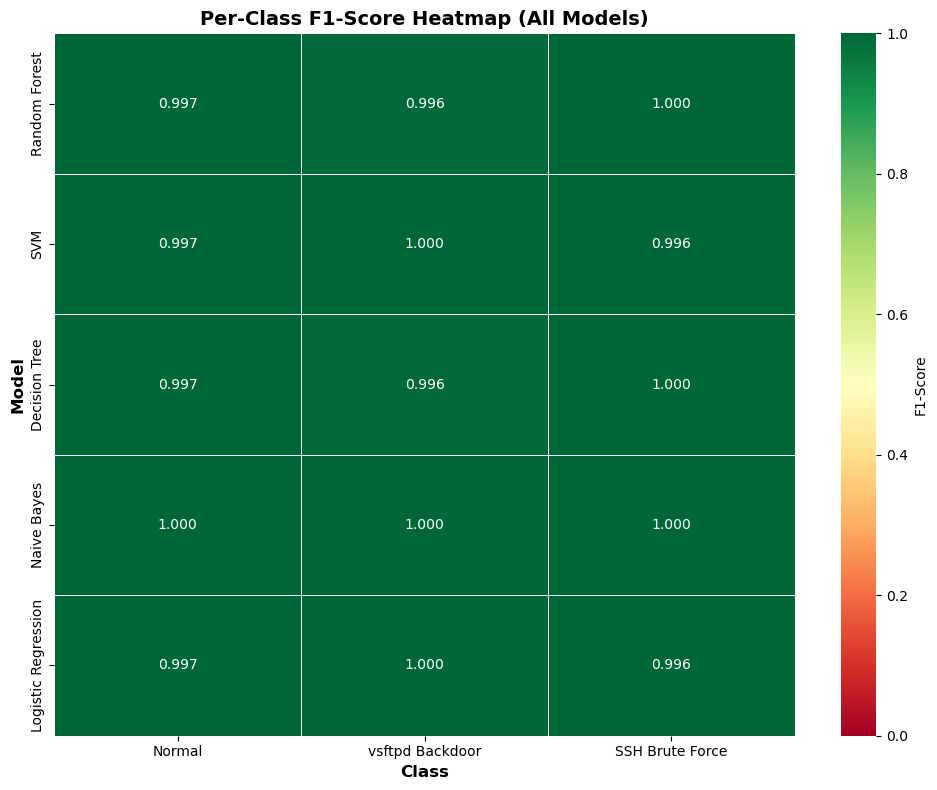

✅ Per-class F1-score heatmap complete!


In [43]:
print("=" * 70)
print("PER-CLASS F1-SCORE HEATMAP")
print("=" * 70)

# Create matrix of F1-scores
f1_matrix = []
model_names_list = list(results.keys())
class_names_list = ['Normal', 'vsftpd Backdoor', 'SSH Brute Force']

for model_name in model_names_list:
    f1_matrix.append(results[model_name]['f1_per_class'])

f1_matrix = np.array(f1_matrix)

# Create heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(f1_matrix, annot=True, fmt='.3f', cmap='RdYlGn',
            xticklabels=class_names_list,
            yticklabels=model_names_list,
            vmin=0, vmax=1,
            cbar_kws={'label': 'F1-Score'},
            linewidths=0.5)

plt.title('Per-Class F1-Score Heatmap (All Models)',
          fontsize=14, fontweight='bold')
plt.xlabel('Class', fontsize=12, fontweight='bold')
plt.ylabel('Model', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print("✅ Per-class F1-score heatmap complete!")

In [44]:
print("=" * 80)
print("COMPREHENSIVE MODEL PERFORMANCE SUMMARY")
print("=" * 80)

# Create comprehensive summary
summary_data = []

for model_name in results.keys():
    result = results[model_name]

    # Overall metrics
    row = {
        'Model': model_name,
        'Test Accuracy': f"{result['test_accuracy']:.4f}",
        'Precision (Weighted)': f"{result['precision']:.4f}",
        'Recall (Weighted)': f"{result['recall']:.4f}",
        'F1-Score (Weighted)': f"{result['f1_score']:.4f}",
        'Overfitting Gap': f"{result['overfitting']:.4f}"
    }

    # Add per-class F1-scores
    for i, class_name in enumerate(['Normal', 'vsftpd', 'SSH BF']):
        row[f'F1 ({class_name})'] = f"{result['f1_per_class'][i]:.4f}"

    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("\n", summary_df.to_string(index=False))

print("\n" + "=" * 80)
print("✅ MODEL EVALUATION COMPLETE!")
print("=" * 80)

COMPREHENSIVE MODEL PERFORMANCE SUMMARY

               Model Test Accuracy Precision (Weighted) Recall (Weighted) F1-Score (Weighted) Overfitting Gap F1 (Normal) F1 (vsftpd) F1 (SSH BF)
      Random Forest        0.9976               0.9976            0.9976              0.9976          0.0018      0.9969      0.9957      1.0000
                SVM        0.9976               0.9976            0.9976              0.9976         -0.0006      0.9968      1.0000      0.9964
      Decision Tree        0.9976               0.9976            0.9976              0.9976          0.0018      0.9969      0.9957      1.0000
        Naive Bayes        1.0000               1.0000            1.0000              1.0000         -0.0006      1.0000      1.0000      1.0000
Logistic Regression        0.9976               0.9976            0.9976              0.9976         -0.0000      0.9968      1.0000      0.9964

✅ MODEL EVALUATION COMPLETE!
